# Speech emotion recognition on ravdess

In [1]:
speech_path, save_path = "data/raw/speech", "data/processed"

from src.utility import show_duration_distribution, plot_history, plot_clusters, plot_classes, plot_encoder_loss
from src.data_processing import FeatureExtractor
from src.dataset import Dataset
from src.loader import Loader

import numpy as np  
from tqdm import tqdm 

import seaborn as sns
sns.set_theme()

from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(1)

import warnings  
warnings.filterwarnings("ignore")

# Dataset analysis

### Audio duration distribution

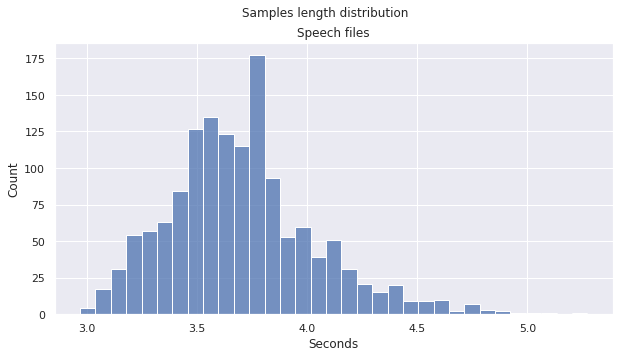

Max len of data samples:  116247.0


In [2]:
MAX_LEN = show_duration_distribution(speech_path, save_path, limit_per_actor=-1)
print("Max len of data samples: ", MAX_LEN)

### Preprocessing and feature extraction

In [3]:
loader = Loader(speech_path, save_path, True, int(MAX_LEN), -1)
data, labels = loader.load(False)

In [4]:
from src.data_processing import identity
ext_features, ext_labels = FeatureExtractor(raw_data=data, 
                                            labels=labels, 
                                            save_path=f"{save_path}/features", 
                                            file_name="full",
                                            augmenter=identity, 
                                            verbose=True, 
                                            only_mfcc=False).get_training_data(overwrite=False)

d = Dataset(original_data=(ext_features, ext_labels), augmented_data=[])
X_train, X_test, y_train, y_test = d.get_training_data(label="all", train_perc=0.98)

Filename: full found on disk



### Classes distribution

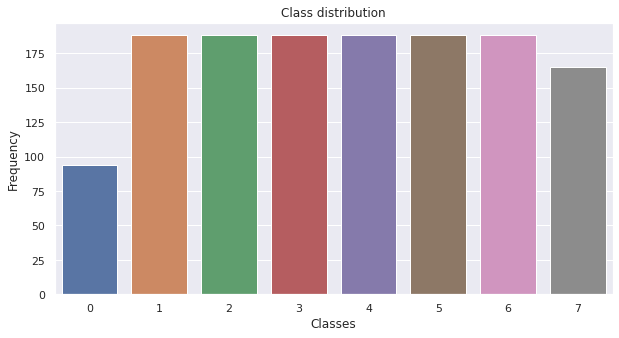

In [5]:
plot_classes(y_train)

### Data visualization

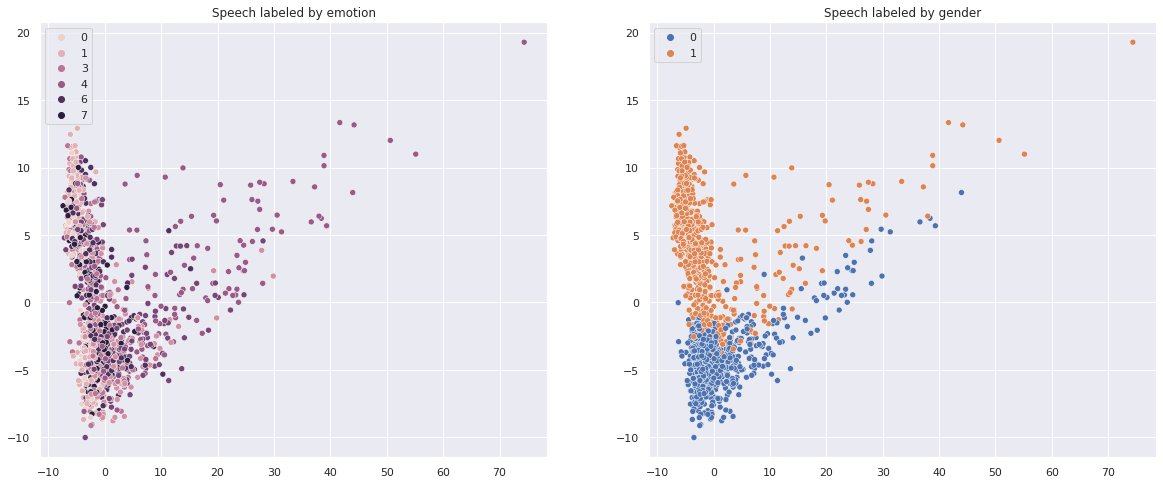

In [6]:
plot_clusters(d)

## Data augmentation for all models

In [ ]:
# parameters after path are not so important, as the raw data is precomputed
loader = Loader(speech_path, save_path, True, 0, -1)
data, labels = loader.load(False)
OVERWRITE = False

from src.data_processing import identity, noise, stretch, speedpitch

orig_features, orig_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="classic", 
                                              augmenter=identity, verbose=True).get_training_data(overwrite=False)

noise_features, noise_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="noise_classic", 
                                                augmenter=noise, verbose=True).get_training_data(overwrite=OVERWRITE)

stretch_features, stretch_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="stretch_classic", 
                                                    augmenter=stretch, verbose=True).get_training_data(overwrite=OVERWRITE)

speed_features, speed_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="speed_classic", 
                                                augmenter=speedpitch, verbose=True).get_training_data(overwrite=OVERWRITE)

original_data = (orig_features, orig_labels)
augmented_data = [(noise_features, noise_labels), (stretch_features, stretch_labels), (speed_features, speed_labels)]

d = Dataset(original_data=original_data, augmented_data=augmented_data)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

In [ ]:
model, history, test_scores = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=50, verbose=2)

In [ ]:
model, history, test_scores = train_nn((resp(X_train), y_train), (resp(X_val), y_val), (resp(X_test), y_test), build_cnn, epochs=50, verbose=2)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2, flatten=True)
build_train_svm((X_train, y_train), (X_val, y_val), (X_test, y_test))
print()
build_train_knn((X_train, y_train), (X_val, y_val), (X_test, y_test))
print()
build_train_tree((X_train, y_train), (X_val, y_val), (X_test, y_test))

### Cross validation on best performing model

In [ ]:
def resp(x):
    return x.reshape(*x.shape, 1)

cv_splits = Dataset(original_data=original_data, augmented_data=augmented_data)\
    .get_cross_val_generator(num_splits=3, data_transform=resp)

In [ ]:
acc = []
loss = []
for (X_train, y_train), (X_test, y_test) in tqdm(cv_splits):
    _, _, test_scores = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_cnn, epochs=1, verbose=2)
    acc.append(test_scores[0])
    loss.append(test_scores[1])
    
print(f"Mean accuracy: {np.mean(acc)} (std: {np.std(acc)})")
print(f"Mean loss: {np.mean(loss)} (std: {np.std(loss)})")